![Pictures/bbc_news_logo.png](Pictures/bbc_news_logo.png)

# <span style='color:Red; font-weight:bold;'> BBC News </span>

### <span style='color:aqua; font-weight:bold;'> About Dataset </span>

<b>Context<b>

Self updating dataset. It collects RSS Feeds from BBC News using a Kernel: https://www.kaggle.com/gpreda/bbc-news-rss-feeds.
    The Kernel is run with a fixed frequency and the dataset is updated using the output of the Notebook.

<b>Contents<b>

    BBC News RSS Feeds. The data contains the following columns:

    *title
    *pubDate
    *guid
    *link
    *description


<b>Collection method<b>

    Uses requests_html and BeautifulSoup to collect RSS Feeds from BBC News site.

<b>Acknowledgements<b>

    The content is proprietary of BBC

<b>Inspiration<b>

    Use the data to analyze the sentiment of news, from title and description


### <span style='color:aqua; font-weight:bold;'> Import Packages and Load the data </span>

In [1]:
#Essentails
import numpy as np
import pandas as pd

#Visulization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as ex
from wordcloud import WordCloud

#Modeling
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from keras.models import Sequential
from keras.layers import Dense

#Misc
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
news_df = pd.read_csv('bbc_news.csv')

# <span style='color:dodgerblue; font-weight:bold;'>Exploratory Data Analysis </span>

In [3]:
news_df.head() # First 5 rows

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...


In [4]:
news_df.tail() # Last 5 rows

,title,pubDate,guid,link,description
37668,Finucane makes history with third medal in Paris,"Sun, 11 Aug 2024 11:24:03 GMT",https://www.bbc.com/sport/olympics/articles/ce...,https://www.bbc.com/sport/olympics/articles/ce...,Emma Finucane makes British Olympic history by...
37669,Family remember Alice at Southport funeral,"Sun, 11 Aug 2024 20:59:44 GMT",https://www.bbc.com/news/articles/cwyj8wz8157o#12,https://www.bbc.com/news/articles/cwyj8wz8157o,A final photo of Alice taken before the Taylor...
37670,'We will not allow hatred and mindless violenc...,"Sun, 11 Aug 2024 18:42:58 GMT",https://www.bbc.com/news/articles/c5y3w69vpgko#12,https://www.bbc.com/news/articles/c5y3w69vpgko,NI's chief constable condemns race hate attack...
37671,Unions to decide whether to call off bin strike,"Sun, 11 Aug 2024 17:51:07 GMT",https://www.bbc.com/news/articles/c39k0n7d2kgo#12,https://www.bbc.com/news/articles/c39k0n7d2kgo,Unions will meet on Monday to decide whether t...
37672,Welsh sixth-form uni applications lowest in UK,"Sun, 11 Aug 2024 21:00:08 GMT",https://www.bbc.com/news/articles/ckg2ngl23m0o#12,https://www.bbc.com/news/articles/ckg2ngl23m0o,A growing gap in applications between Wales an...


In [5]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37673 entries, 0 to 37672
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        37673 non-null  object
 1   pubDate      37673 non-null  object
 2   guid         37673 non-null  object
 3   link         37673 non-null  object
 4   description  37673 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


Convert 'pubDate' to datetime

In [6]:
news_df['pubDate'] = pd.to_datetime(news_df['pubDate'], errors='coerce')

In [7]:
news_df.isnull().sum()

title          0
pubDate        0
guid           0
link           0
description    0
dtype: int64

In [8]:
news_df.describe()

,pubDate
count,37673
mean,2023-06-09 07:55:05.731850240
min,2013-08-30 01:01:55
25%,2022-10-20 16:08:22
50%,2023-06-25 15:38:13
75%,2024-01-19 12:07:42
max,2024-08-12 00:06:56


make a plot how many news per day. =/80

In [9]:
# Check for duplicates across all columns
duplicated = news_df.duplicated()

# Print the number of duplicated instances
print("Number of duplicated instances:", duplicated.sum())

# Print the duplicated instances
news_df[duplicated]

Number of duplicated instances: 0


,title,pubDate,guid,link,description


Perform frequency analysis on the words used in title and description to identify common themes or keywords.

In [10]:
def show_wordcloud(data, mask=None, title=""):
    text = " ".join(t for t in data.dropna())
    all_stopwords = set(stopwords.words('english'))  # Load stopwords
    all_stopwords.remove('not')  # Remove 'not' from stopwords
    wordcloud = WordCloud(stopwords=all_stopwords, scale=4, max_font_size=50, max_words=500,mask=mask, background_color="Black").generate(text)
    fig = plt.figure(1, figsize=(16,16))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

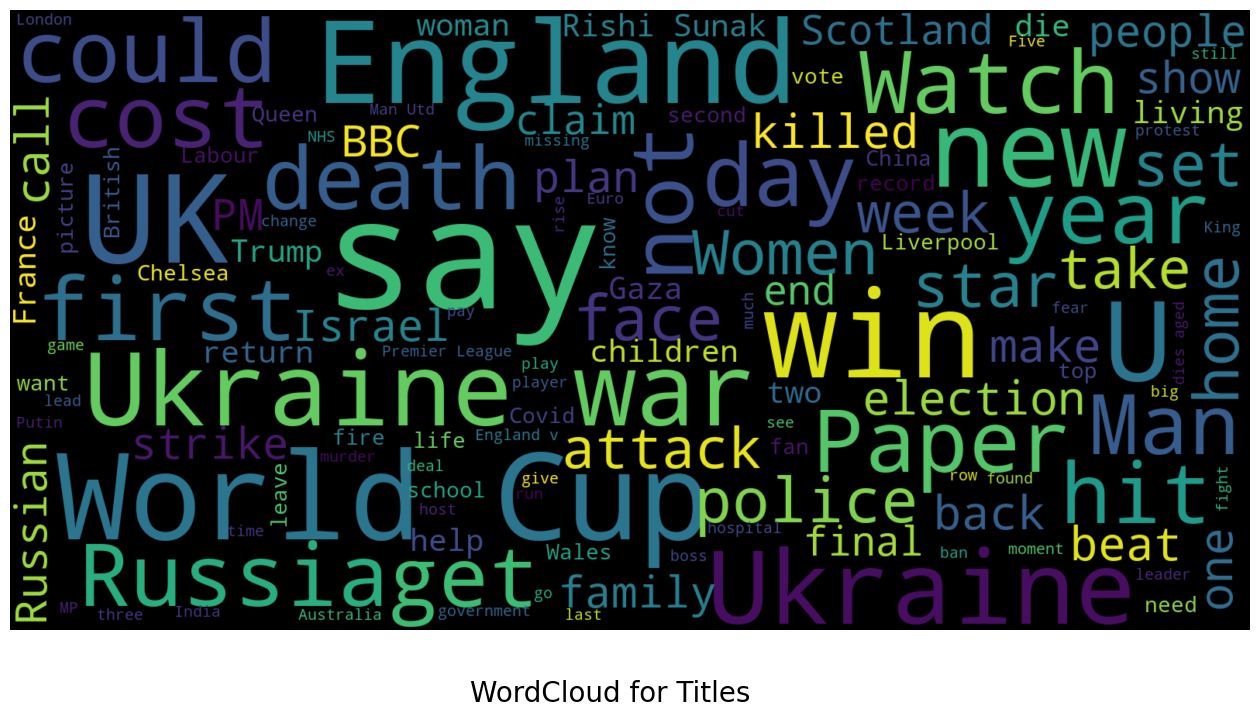

In [11]:
show_wordcloud(news_df['title'], title = 'WordCloud for Titles', mask = None)

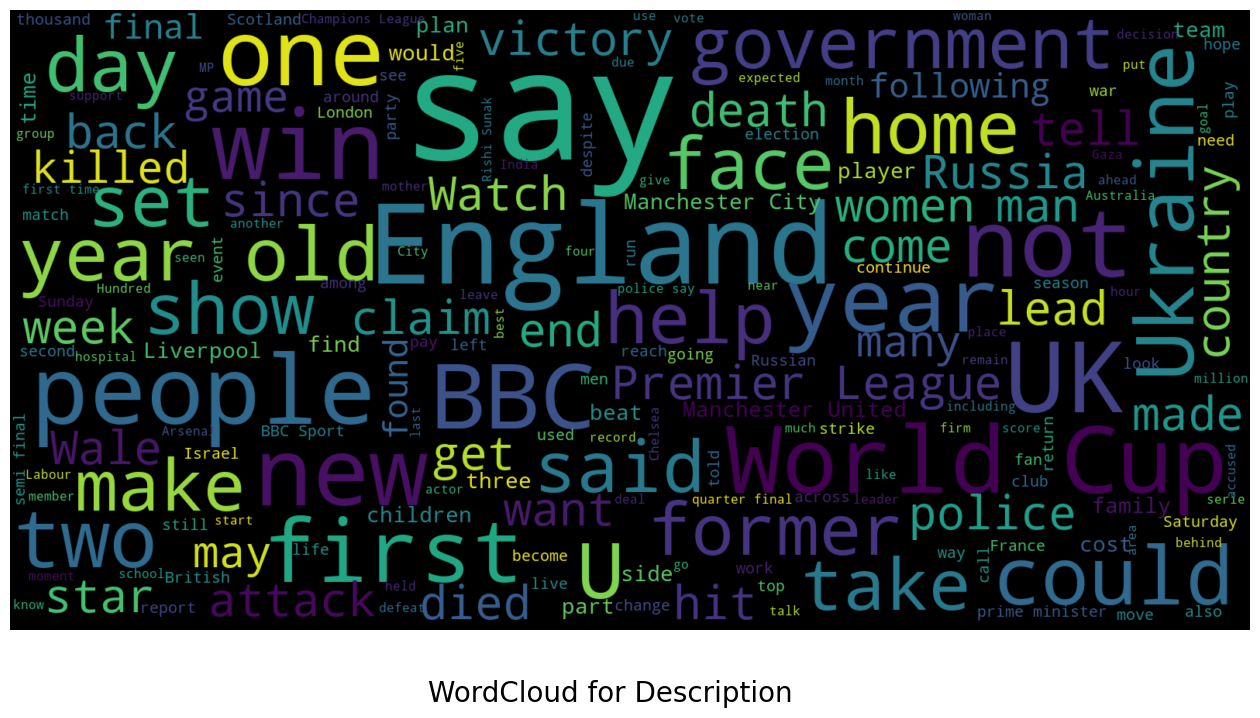

In [12]:

show_wordcloud(news_df['description'], title = 'WordCloud for Description', mask = None)

histograms for article length distributions and publication times.

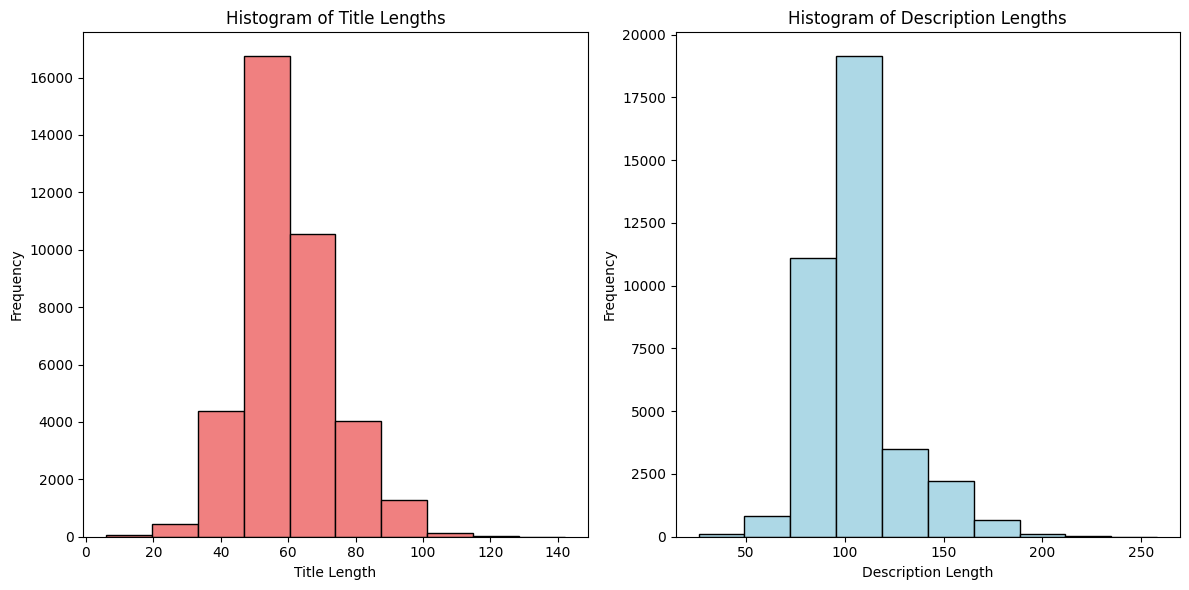

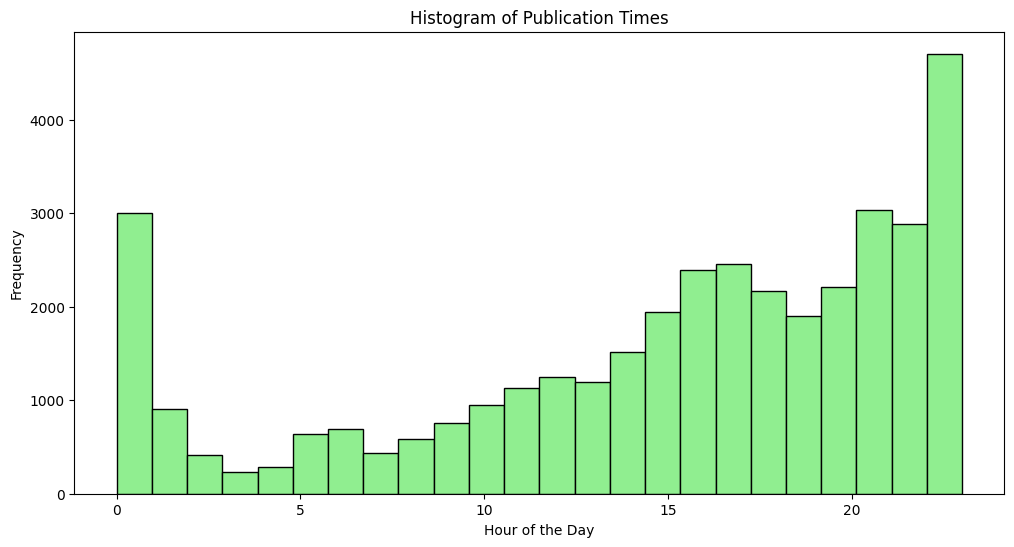

In [13]:
# Calculate lengths
news_df['title_length'] = news_df['title'].apply(len)
news_df['description_length'] = news_df['description'].apply(len)

# Extract date and time from pubDate
news_df['pubDate'] = pd.to_datetime(news_df['pubDate'], format='%a, %d %b %Y %H:%M:%S GMT')
news_df['hour'] = news_df['pubDate'].dt.hour

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(news_df['title_length'], bins=10, color='lightcoral', edgecolor='black')
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.title('Histogram of Title Lengths')

plt.subplot(1, 2, 2)
plt.hist(news_df['description_length'], bins=10, color='lightblue', edgecolor='black')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.title('Histogram of Description Lengths')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(news_df['hour'], bins=24, color='lightgreen', edgecolor='black')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.title('Histogram of Publication Times')
plt.show()

# <span style='color:dodgerblue; font-weight:bold;'>Data Preprocessing</span> 

* Cleaning the Text: Remove special characters, HTML tags (if any), and unnecessary whitespaces. Convert all text to lowercase to ensure consistency.
* Tokenization: Split the text into individual words or tokens, which will make it easier to analyze.
* Stopwords Removal: Remove common stopwords like "the," "is," "in," etc., as they do not carry significant meaning.
* Stemming/Lemmatization: Optionally, reduce words to their root form (e.g., "running" to "run") using stemming or lemmatization.

This function processes and cleans the text, returning the cleaned data as a dictionary.

In [14]:
def clean_text(news_df, columns_to_clean=['title', 'description']):
    """
    Cleans the text in the specified columns of a DataFrame by performing:
    1. Lowercasing
    2. Removing non-alphabetic characters
    3. Removing stopwords (except 'not')
    4. Applying stemming

    Parameters:
    news_df (pd.DataFrame): The DataFrame containing the text data.
    columns_to_clean (list): List of column names to clean.

    Returns:
    cleaned_data (dict): A dictionary containing the cleaned text for each specified column.
    """

    # Initialize a dictionary to store the cleaned text
    cleaned_data = {col: [] for col in columns_to_clean}

    # Initialize the Porter Stemmer
    ps = PorterStemmer()

    # Load stopwords and remove 'not' to preserve negations in sentiment analysis
    all_stopwords = set(stopwords.words('english'))
    all_stopwords.remove('not')

    # Iterate through each row in the DataFrame
    for i in range(len(news_df)):
        for col in columns_to_clean:
            # Step 1: Remove non-alphabetical characters and convert to lowercase
            text = re.sub(r'[^a-zA-Z]', ' ', news_df[col][i])
            text = text.lower()

            # Step 2: Tokenize (split the text into individual words)
            tokens = text.split()

            # Step 3: Remove stopwords and apply stemming
            cleaned_tokens = [ps.stem(word) for word in tokens if word not in all_stopwords]

            # Step 4: Join the cleaned tokens back into a single string
            cleaned_text = ' '.join(cleaned_tokens)

            # Append the cleaned text to the respective column in the dictionary
            cleaned_data[col].append(cleaned_text)

    # Return the dictionary with cleaned text data
    return cleaned_data

In [15]:
cleaned_data = clean_text(news_df)

This function randomly selects a row from your DataFrame, then prints both the original and the cleaned version of the text.

In [16]:
def show_random_sample(news_df, cleaned_data):
    """
    Displays a random sample of the text before and after cleaning.

    Parameters:
    news_df (pd.DataFrame): The original DataFrame with the text data.
    cleaned_data (dict): The cleaned text data.
    """
    # Choose a random index
    random_idx = random.randint(0, len(news_df) - 1)

    # Display original and cleaned text
    print(f"Original Title: {news_df['title'][random_idx]}")
    print(f"Cleaned Title: {cleaned_data['title'][random_idx]}\n")
    print(f"Original Description: {news_df['description'][random_idx]}")
    print(f"Cleaned Description: {cleaned_data['description'][random_idx]}")

# Example usage:
show_random_sample(news_df, cleaned_data)

Original Title: Newspaper headlines: Putin 'humiliated by mutiny' and Russia 'on the brink'
Cleaned Title: newspap headlin putin humili mutini russia brink

Original Description: Sunday's front pages react to an extraordinary 24 hours which saw the Wagner group revolt in Russia.
Cleaned Description: sunday front page react extraordinari hour saw wagner group revolt russia


In [17]:
news_df['title'] = cleaned_data['title']
news_df['description'] = cleaned_data['description']

# <span style='color:dodgerblue; font-weight:bold;'>Sentiment Analysis Model</span> 

## VADER (Valence Aware Dictionary and sEntiment Reasoner)

* Best For: Social media posts, news headlines, or short text.
* Why: VADER is a rule-based model that is specifically tuned for social media and news content. It can handle negations and emoticons effectively. It works well on shorter texts like headlines, which are often found in news data.
* Pros: Easy to implement, fast, and interpretable.
* Cons: Limited to short texts; less accurate on complex language and sarcasm.

In [18]:
# Initialize the VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis on 'title' and 'description' columns
news_df['sentiment_title_score'] = news_df['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
news_df['sentiment_description_score'] = news_df['description'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Function to classify sentiment based on compound score
def classify_sentiment(compound_score):
    if compound_score > 0.05:
        return 'Positive'
    elif compound_score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the classification function to both title and description sentiment scores
news_df['sentiment_title'] = news_df['sentiment_title_score'].apply(classify_sentiment)
news_df['sentiment_description'] = news_df['sentiment_description_score'].apply(classify_sentiment)

Display the DataFrame with the new sentiment columns

In [19]:
news_df.head(3)

,title,pubDate,guid,link,description,title_length,description_length,hour,sentiment_title_score,sentiment_description_score,sentiment_title,sentiment_description
0,ukrain angri zelenski vow punish russian atroc,2022-03-07 08:01:56,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,ukrainian presid say countri not forgiv forget...,57,99,8,-0.5267,0.6602,Negative,Positive
1,war ukrain take cover town attack,2022-03-06 22:49:58,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,jeremi bowen frontlin irpin resid came russian...,51,102,22,-0.7906,-0.3400,Negative,Negative
2,ukrain war catastroph global food,2022-03-07 00:14:42,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,one world biggest fertilis firm say conflict c...,42,101,0,-0.5994,-0.5994,Negative,Negative


# <span style='color:dodgerblue; font-weight:bold;'>Analyze Sentiment Distribution</span> 

Overall sentiment distribution to get a sense of how sentiments are spread across the data.

In [20]:
# Count the number of each sentiment type for titles and descriptions
title_sentiment_distribution = news_df['sentiment_title'].value_counts()
description_sentiment_distribution = news_df['sentiment_description'].value_counts()

print("Title Sentiment Distribution:")
print(title_sentiment_distribution)

print("\nDescription Sentiment Distribution:")
print(description_sentiment_distribution)

Title Sentiment Distribution:
sentiment_title
Neutral     16023
Negative    13075
Positive     8575
Name: count, dtype: int64

Description Sentiment Distribution:
sentiment_description
Neutral     13595
Negative    12529
Positive    11549
Name: count, dtype: int64


Visualize Sentiments

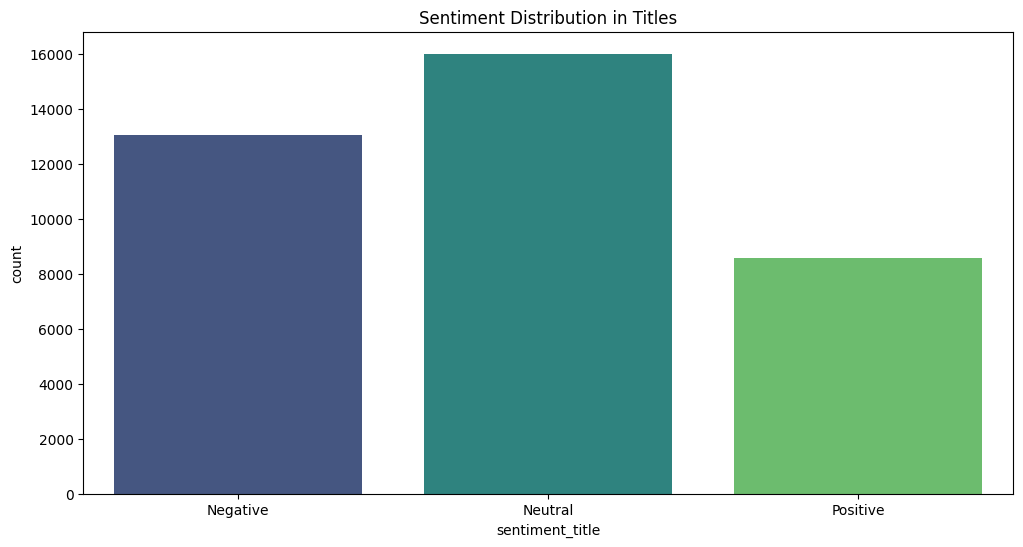

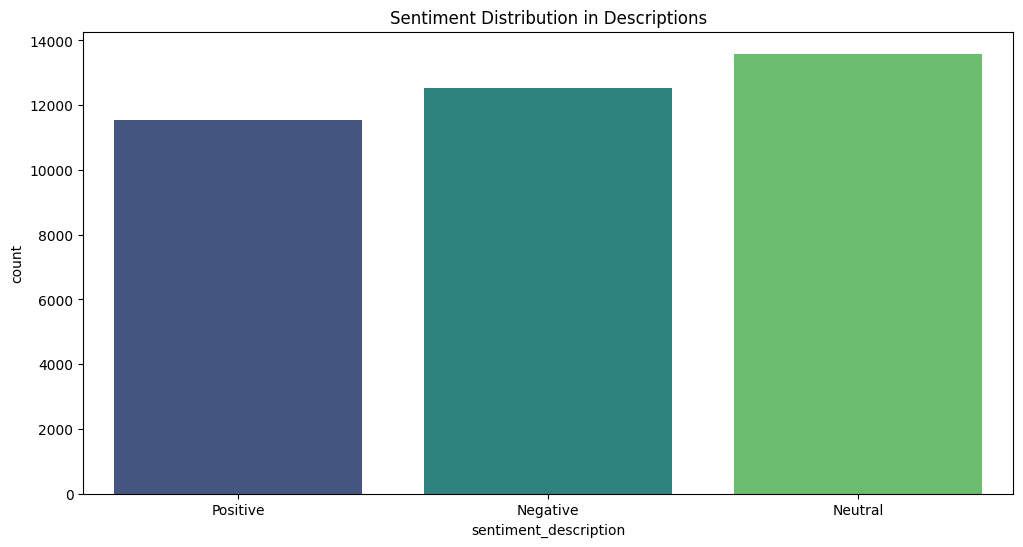

In [21]:
# Plot sentiment distribution for titles
plt.figure(figsize=(12, 6))
sns.countplot(x='sentiment_title', data=news_df, palette='viridis')
plt.title('Sentiment Distribution in Titles')
plt.show();

# Plot sentiment distribution for descriptions
plt.figure(figsize=(12, 6))
sns.countplot(x='sentiment_description', data=news_df, palette='viridis')
plt.title('Sentiment Distribution in Descriptions')
plt.show();

Perform Correlation Analysis

In [22]:
# Compute correlation between title and description sentiments
correlation = news_df[['sentiment_title_score', 'sentiment_description_score']].corr().iloc[0, 1]
print(f"Correlation between title and description sentiments: {correlation:.2f}")

Correlation between title and description sentiments: 0.46


Explore Sentiment Over Time

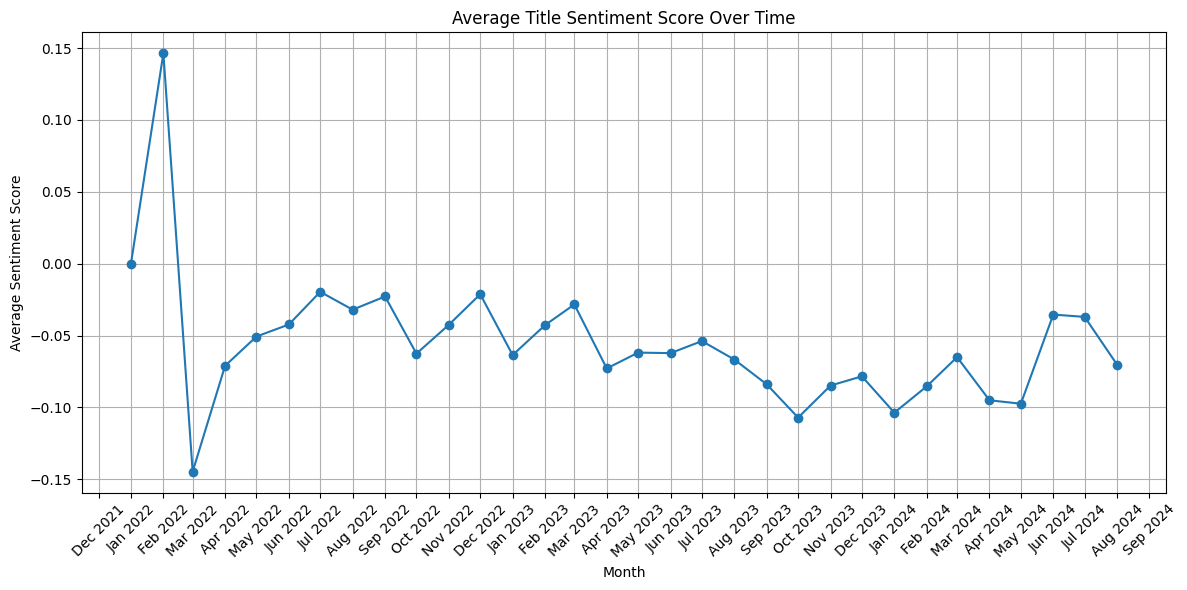

In [23]:
# Ensure 'pubDate' is in datetime format
news_df['pubDate'] = pd.to_datetime(news_df['pubDate'])

# Extract year and month for analysis
news_df['year_month'] = news_df['pubDate'].dt.to_period('M')

# Filter data to start from January 2022
start_date = '2022-01'
filtered_df = news_df[news_df['year_month'] >= start_date]

# Convert 'year_month' to datetime for plotting
filtered_df['year_month'] = filtered_df['year_month'].dt.to_timestamp()

# Average sentiment score by month
monthly_sentiment = filtered_df.groupby('year_month')['sentiment_title_score'].mean()

# Plot the average sentiment score over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_sentiment.index, monthly_sentiment.values, marker='o', linestyle='-')

# Format the X-axis to show all month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title('Average Title Sentiment Score Over Time')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Save the DataFrame with sentiment results for further use or sharing.

In [24]:
# Save the DataFrame with sentiment analysis results
news_df.to_csv('news_sentiment_analysis.csv', index=False)

# Deep Learning

In [26]:
# Drop 'guid' and 'link' columns
news_df = news_df.drop(columns=['guid', 'link','year_month','title_length','description_length','hour'])

In [31]:
news_df.head(2)

,title,pubDate,description,sentiment_title_score,sentiment_description_score,sentiment_title,sentiment_description
0,ukrain angri zelenski vow punish russian atroc,2022-03-07 08:01:56,ukrainian presid say countri not forgiv forget...,-0.5267,0.6602,Negative,Positive
1,war ukrain take cover town attack,2022-03-06 22:49:58,jeremi bowen frontlin irpin resid came russian...,-0.7906,-0.3400,Negative,Negative


Split your dataset into training and testing sets.

In [30]:
X = news_df[['sentiment_title_score', 'sentiment_description_score']]
y = le.transform(news_df['sentiment_title'])  # Convert labels to numerical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

NameError: name 'le' is not defined

Build and Train the Model:
Use a deep learning model suitable for multi-class classification.

In [ ]:
# Build the model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(le.classes_), activation='softmax'))  # Output layer for multi-class classification

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')

# Predict sentiment for new data
predictions = model.predict(X_test)
predicted_labels = le.inverse_transform(predictions.argmax(axis=1))

# Conclusion